In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
import os
from scipy.stats import beta

scalar = float # a scale value (0.0 to 1.0)
def hsv_to_rgb( h:scalar, s:scalar, v:scalar) -> tuple:
    if s:
        if h == 1.0: h = 0.0
        i = int(h*6.0); f = h*6.0 - i
        
        w = v * (1.0 - s)
        q = v * (1.0 - s * f)
        t = v * (1.0 - s * (1.0 - f))
        
        if i==0: return (v, t, w)
        if i==1: return (q, v, w)
        if i==2: return (w, v, t)
        if i==3: return (w, q, v)
        if i==4: return (t, w, v)
        if i==5: return (v, w, q)
    else: return (v, v, v)

# Test infer gene phase and amplitude

Cry1
Cry2
Nr1d1
Nr1d2
Per1
Per2
Per3
Ciart
Clock
Arntl
Npas2
Dbp
Tef
Hlf
Nfil3
Bhlhe40
Fbxl3
Csnk1e
Rora
Rorb
Rorc
Gnai2
Xkr4


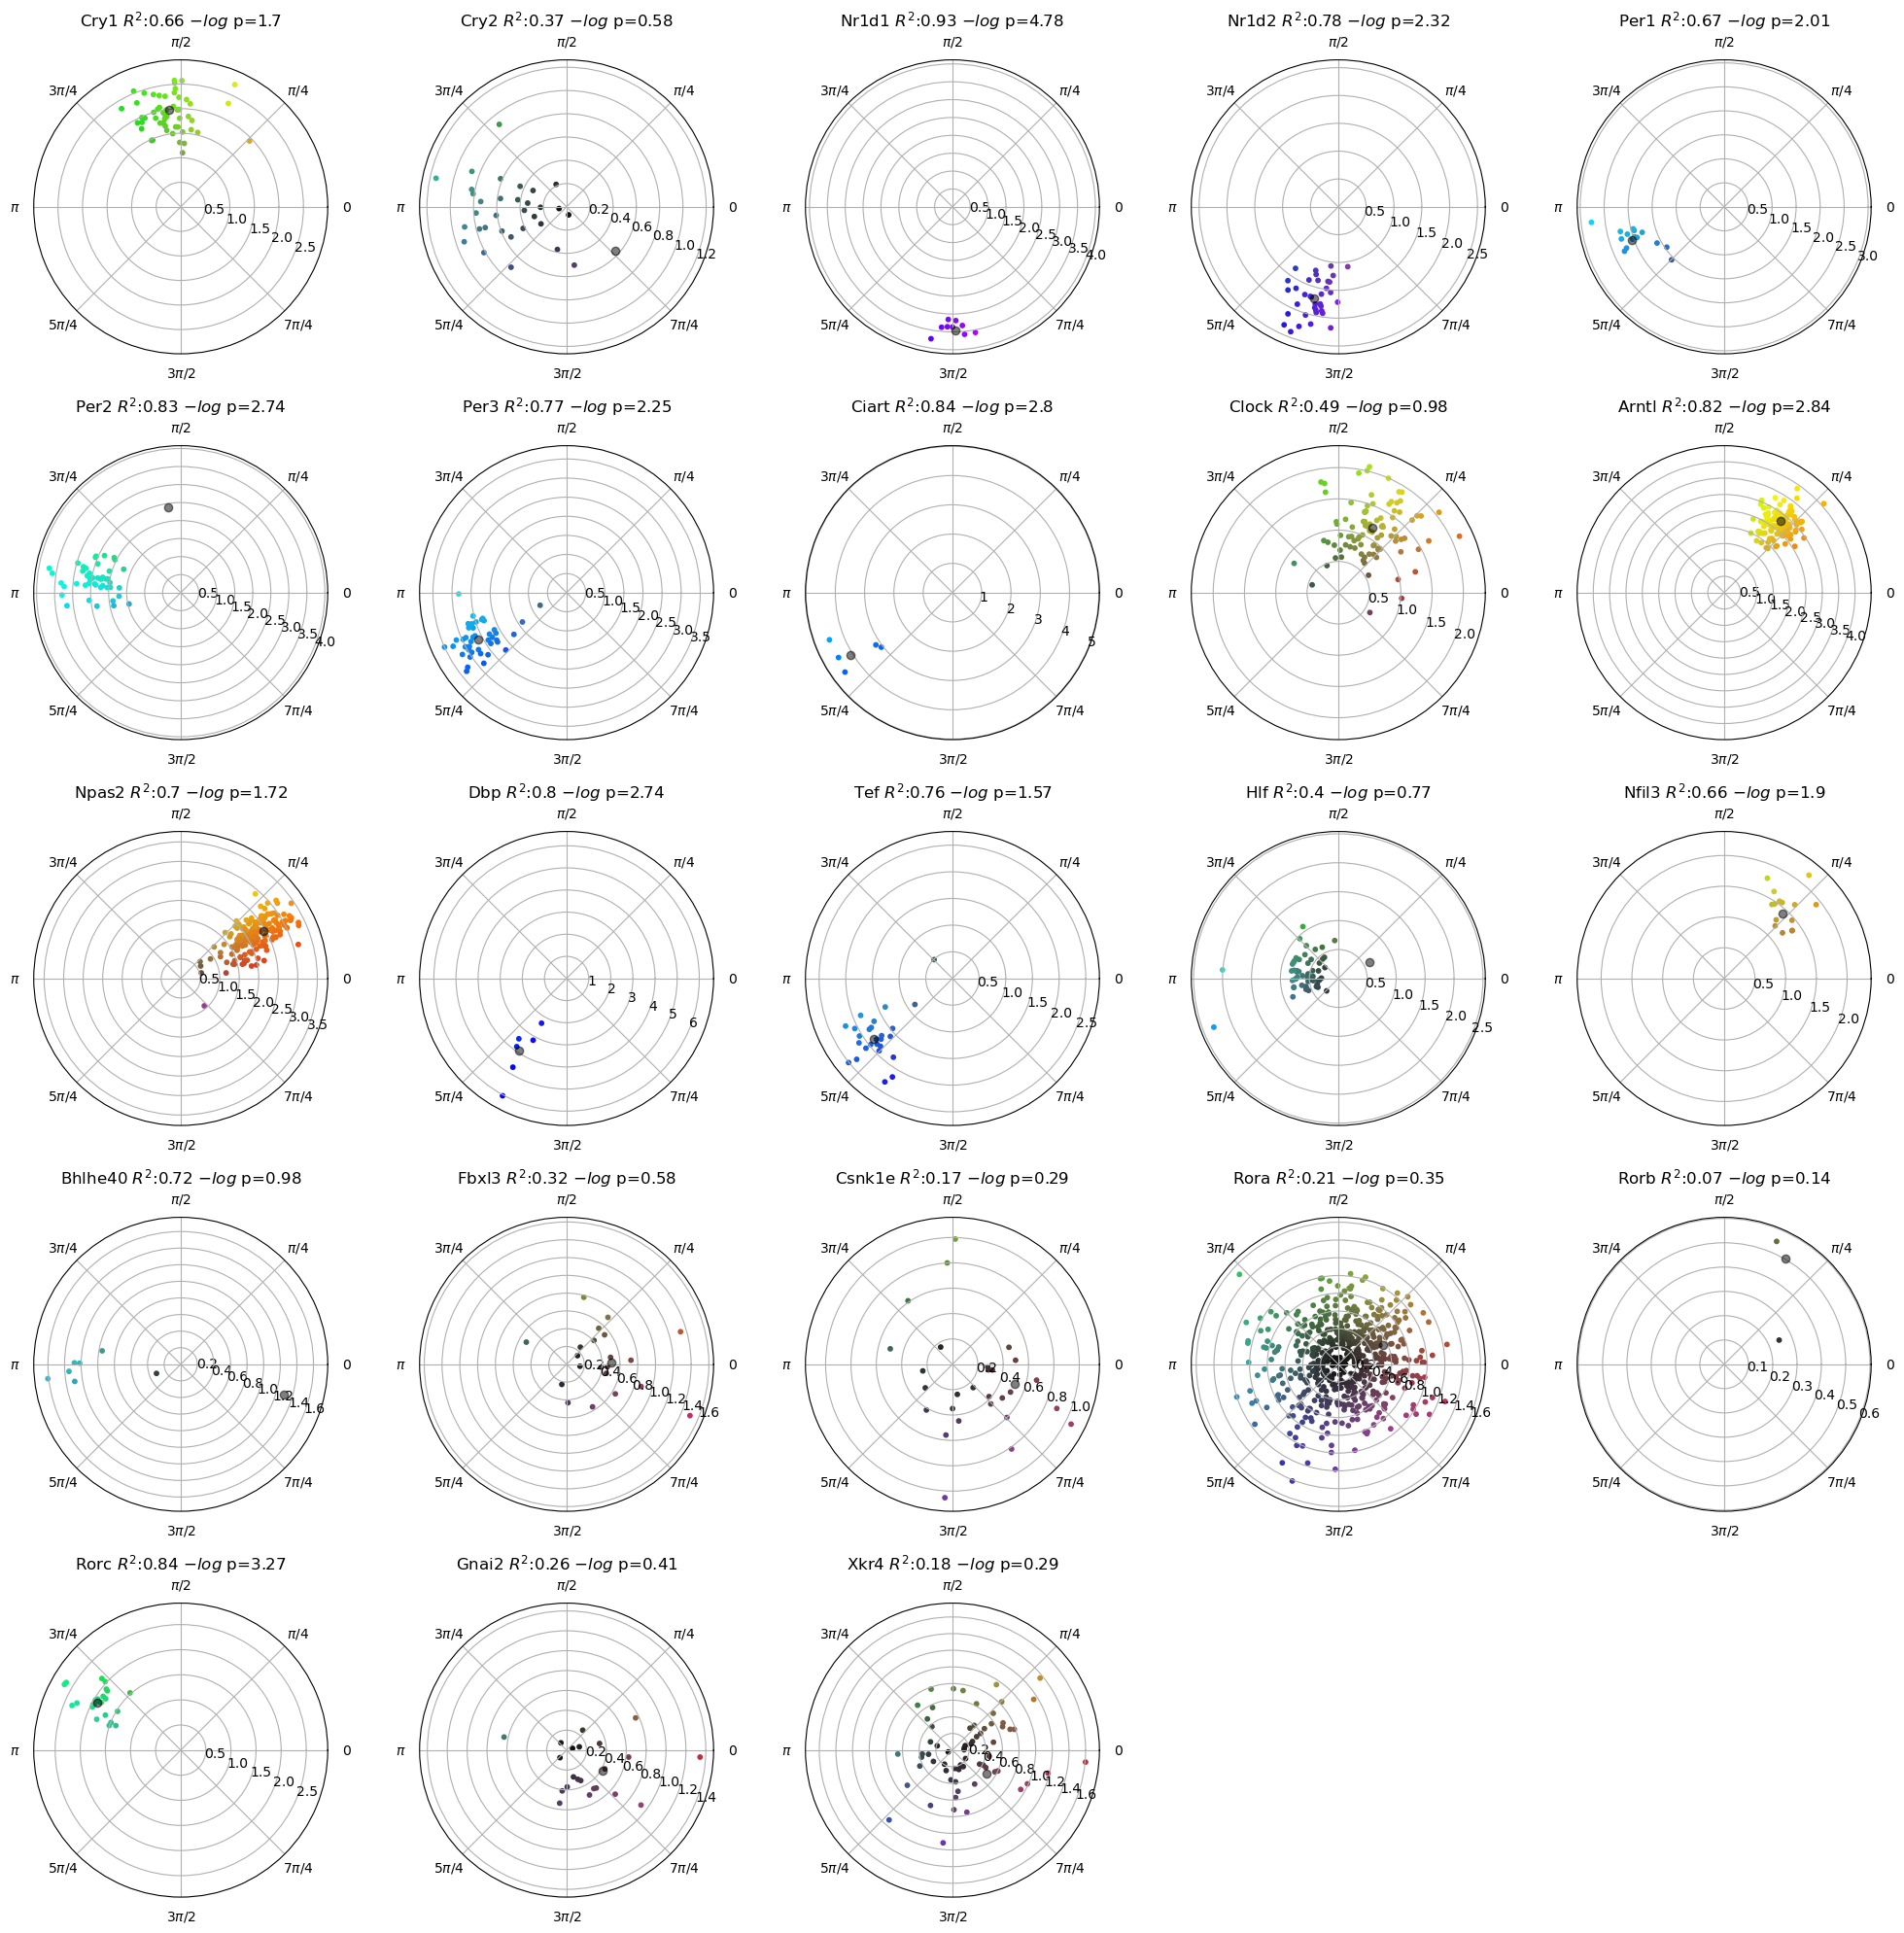

In [227]:
data_folder='../results/binned_norm_counts/'
Samples = [f'PRO_SEQ_CT{4*i:02d}_S{i+1}_R1_001' for i in range(12)]
Strands = ['forward','reverse']
bin_size = 1000
T = np.arange(0,48,4)

# awk '$3=="gene"' resources/genome/GRCm39/gencode.vM33.primary_assembly.annotation.gtf | grep "^chr" > resources/genome/GRCm39/gene.gtf
gtf = pd.read_csv('../resources/genome/GRCm39/gene.gtf',sep='\t',header=None)
gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')

f = {}
for sample in Samples:
    t = int(sample.split('_')[2][2:])
    f[t] = {}
    for strand in Strands:
        if strand=='forward':
            f[t]['+'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")
        elif strand=='reverse':
            f[t]['-'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")

Genes = ["Cry1","Cry2","Nr1d1","Nr1d2","Per1","Per2","Per3","Ciart","Clock","Arntl","Npas2","Dbp","Tef","Hlf","Nfil3","Bhlhe40","Fbxl3","Csnk1e","Rora","Rorb","Rorc","Gnai2","Xkr4"]
n_col = int(np.ceil(np.sqrt(len(Genes))))
n_row = int(np.ceil(len(Genes)/n_col))
fig = plt.figure(figsize=(n_col*4,n_row*4))
for g, gene in enumerate(Genes):
    print(gene)

    coord = gtf.loc[gtf.gene_name==gene,['chr','start','end','strand']]
    chr = coord.chr.values[0]
    start = coord.start.values[0]
    end = coord.end.values[0]
    strand = coord.strand.values[0]

    Bins = np.arange(start - start%bin_size,end + bin_size - end%bin_size,bin_size)

    X = np.zeros((len(Bins),len(T)))
    X[:] = np.nan
    df = pd.DataFrame(X,index=Bins,columns=T)

    for t in T:
        vals = f[t][strand].intervals(chr,start,end)
        if vals is None:
            df.loc[:,t] = np.nan
            continue

        bins = [vals[i][0] for i in range(len(vals))]
        counts = [vals[i][2] for i in range(len(vals))]
        df.loc[bins,t] = counts

    idx_out = np.isnan(df.values).sum(1) > .8*T.shape[0]
    df = df.loc[~idx_out,:]
    df[np.isnan(df.values)] = 0

    X = np.log(df.values + 1/bin_size)
    w = df.values.sum(1)
    w = w/w.sum()
    alpha = 0.8*(w/np.max(w)) + .1

    # fourier transform
    n = 1
    N = len(T)
    P = 24
    f_n = np.sum(X*np.exp(-1j*2*n*np.pi*T/P),1)
    a_n = 4/N * np.abs(f_n) # *4 ??
    #phi_n = np.angle(f_n)
    phi_n = np.arctan2(np.imag(f_n),np.real(f_n)) # ?? -im/re ??
    mu_n = 1/N * np.sum(X,1)

    # averaeg per gene
    #f_m = np.sum(f_n*w)
    a = np.sum(a_n*w)
    phi = np.sum(phi_n*w)
    #phi = np.arctan2(np.imag(f_m),np.real(f_m))
    #mu = 1/N * np.sum(mu_n*w)
    
    #compute the residuals and statistics of the fit (pval)
    x_hat = mu_n[:,None] + 0.5 * a_n[:,None] * np.cos(2 * np.pi / P * T[None,:] + phi_n[:,None])
    res = X - x_hat
    sig2_1 = np.var(res,1)
    sig2 = np.var(X,1)
    R2 = 1 - sig2_1 / sig2
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    phi_n[phi_n<0] += np.pi * 2

    # get color
    color = len(phi_n)*[(0,0,0)]
    for i,p in enumerate(phi_n):
        # normalize phase and amplitude in [0,1]
        h = (p % (2*np.pi))/(2*np.pi)
        s = 1 - np.exp(-a_n[i])
        v = 1 - np.exp(-a_n[i])
        color[i] = hsv_to_rgb(h,s,v)

    # plot in polar coordinates
    ax = fig.add_subplot(n_row,n_col,g+1,projection='polar')
    ax.scatter(phi_n,a_n,s=10,marker='o',c=color)
    ax.plot(phi,a,'o',color='k',alpha=0.5)
    ax.set_rmax(1.1*np.max(a_n))
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.set_xticks(np.arange(0,2*np.pi,np.pi/4))
    ax.set_xticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$',r'$5\pi/4$',r'$3\pi/2$',r'$7\pi/4$'])
    ax.grid(True)
    ax.set_title(fr"{gene} $R^2$:{np.round(np.mean(R2),2)} $-log$ p={np.round(-np.log10(np.mean(pval)),2)}")

plt.tight_layout()
plt.savefig('../results/fig/gene_phase_amp.pdf')



# Test bin spatial wave

chr19
+


1.256637061435917
0.9155181268004348
0.6669972311197192
0.4859382827035477
0.35402847804999205
0.25792609418026946
0.18791106982556152
0.1369018915096965
0.09973934966328005
0.0726647218789483
0.05293960531696592
0.03856894705776157
0.028099258924162904
0.02047160766159044
0.014914511495878295
0.01086591032994643
0.007916317428905743
0.005767402797580955
0.004201819258546651
0.003061219356639826
0.002230239658787149
0.0016248325768744463
0.001183765561907451
0.0008624278744174538
0.0006283185307179586
0.0
-0.0006283185307179586
-0.0008624278744174538
-0.001183765561907451
-0.0016248325768744463
-0.002230239658787149
-0.003061219356639826
-0.004201819258546651
-0.005767402797580955
-0.007916317428905743
-0.01086591032994643
-0.014914511495878295
-0.02047160766159044
-0.028099258924162904
-0.03856894705776157
-0.05293960531696592
-0.0726647218789483
-0.09973934966328005
-0.1369018915096965
-0.18791106982556152
-0.25792609418026946
-0.35402847804999205
-0.4859382827035477
-0.6669972311197

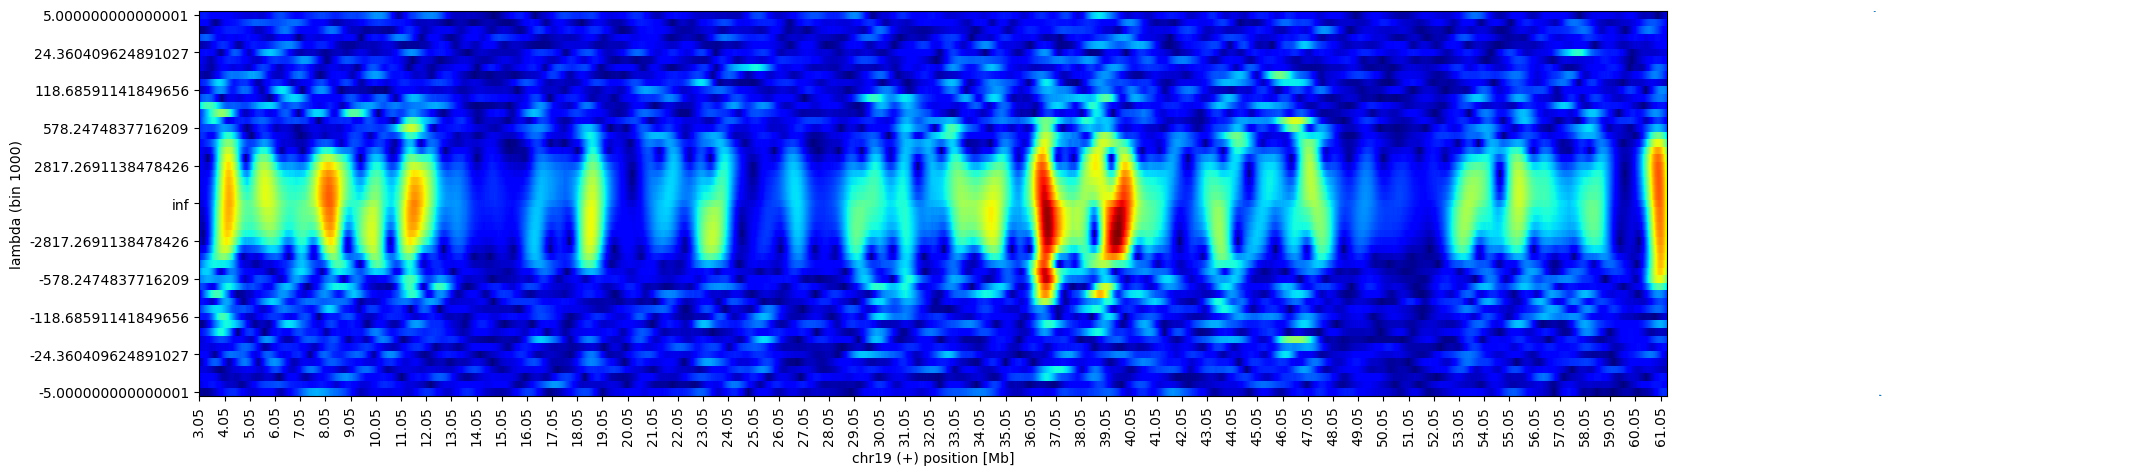

In [75]:
# Parameters
T = np.arange(0,48,4)
n = 1
N = len(T)
P = 24
omega = 2*np.pi*n/P

CHR = [f'chr{i}' for i in range(1,20)] + ['chrX','chrY','chrM']
Samples = [f'PRO_SEQ_CT{4*i:02d}_S{i+1}_R1_001' for i in range(12)]
Strands = ['+','-']

bw_folder = '../results/binned_norm_counts'
bin_size = 1_000
WIN_BP = [1_000_000,3_000_000,10_000_000]
WIN = [int(win/bin_size) for win in WIN_BP]
win = WIN[0]
sigma = 2/5*win
w = np.exp(-np.arange(-win,win+1)**2/(2*sigma**2))

# get wave length range: 5 bins to 10Mb
N_lambda = 51
l_min = 5
l_max = int(10_000_000/bin_size)
Lambda = np.logspace(np.log10(l_min),np.log10(l_max),int((N_lambda-1)/2))
Lambda = np.concatenate([Lambda,[np.inf],-np.flip(Lambda)])

# get wave number range (in bins)
K = 2*np.pi/Lambda

f = {}
for sample in Samples:
    t = int(sample.split('_')[2][2:])
    f[t] = {}
    for strand in Strands:
        if strand=='+':
            fin = f"{bw_folder}/{sample}/NormCoverage_3p_forward_bin{bin_size}bp.bw"
        elif strand=='-':
            fin = f"{bw_folder}/{sample}/NormCoverage_3p_reverse_bin{bin_size}bp.bw"
        f[t][strand] = bw.open(fin)


for chr in CHR[-4:-3]:
    print(chr)
    for strand in Strands[:1]:
        print(strand)
        # fill-in position x time table
        df = pd.DataFrame(columns=['start','end'])
        for t in T:
            df_t = pd.DataFrame(f[t][strand].intervals(chr))
            df_t.columns = ['start','end',f"{t}"]
            df = pd.merge(df,df_t,on=['start','end'],how='outer')
        df.sort_values('start',inplace=True)
        df.reset_index(inplace=True,drop=True)
            
        # fill missing values
        starts = np.sort( list( set(np.arange(df.start.values[0],df.end.values[-1],bin_size,dtype='int')) - set(df.start.values) ) )
        ends = starts + bin_size
        df_missing = pd.DataFrame({'start':starts,'end':ends})
        df = pd.concat([df,df_missing],axis=0)
        df.sort_values('start',inplace=True)
        df.reset_index(inplace=True,drop=True)

        # Get matrix
        X = df[[str(t) for t in T]].values
        N_pos, N_time = X.shape

        # keep only bins with less than 75% nan values (at least 4 time points with data)
        #X[np.isnan(X)] = 0
        # log transform and add pseudo counts and sum for gene expression
        X = np.log(X + 1/bin_size)

        # Add a third dimention to X with X shifted by bin
        X_b = np.zeros((N_pos,N_time,win*2+1))
        X_b[:] = np.nan
        for i,shift in enumerate(range(-win,win+1)):
            if shift < 0:
                X_b[:shift,:,i] = X[-shift:,:]
            elif shift > 0:
                X_b[shift:,:,i] = X[:-shift,:]
            else:
                X_b[:,:,i] = X

        # spatio-temporal fourier transform
        d = np.arange(-win,win+1)
        f_k = np.zeros((N_pos,N_lambda),dtype=complex)
        for j,k in enumerate(K):
            print(k)
            f_k[:,j] = np.sum( np.nansum( X_b*np.exp(-1j*(omega*T[None,:,None] - k*d[None,None,:]))*w[None,None,:],2) ,1)
        
        a_k = 4/N * np.abs(f_k) # *4 ??
        phi_k = np.arctan2(np.imag(f_k),np.real(f_k)) # ?? -im/re ??
        mu_k = 1/N * np.sum(np.sum(X_b*w,2),1)

        # plot amplitude as a function of position and k
        # plot amplitude as a function of position and k
        fig, axes = plt.subplots(1, 2, width_ratios=[5, 1],figsize=(25,5))

        ax = axes[0]
        ax.imshow(a_k.T,aspect='auto',cmap='jet',interpolation='none')
        ax.set_xlabel(f"{chr} ({strand}) position [Mb]")
        ax.set_ylabel(f"lambda (bin {bin_size})")
        ax.xaxis.set_ticks(np.arange(0,len(df.start.values),1000))
        ax.xaxis.set_ticklabels(df.start.values[::1000]/1e6,rotation=90)

        ax.yaxis.set_ticks(np.arange(0,len(Lambda),5))
        ax.yaxis.set_ticklabels(Lambda[::5])

        # plot sum amplitude as a function of k
        ax = axes[1]
        ax.plot(np.mean(a_k,0),Lambda)
        ax.set_ylim([Lambda[0],Lambda[-1]])
        ax.axis('off')

        plt.savefig(f"../results/fig/space_time_Fourier/{chr}_{strand}_amp_k.pdf")
                
        # compute fit's R2 and p-value
        #x_hat = mu_k[:,None] + 0.5 * a_k[:,None] * np.cos(2 * np.pi / P * T[None,:] + phi_k[:,None])
        #sig2_res = np.var(X - x_hat,1)
        #sig2_tot = np.var(X,1)
        #R2 = np.zeros(sig2_res.shape)
        #R2[sig2_tot==0] = 0
        #R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
        #p = 3
        #pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
        #phi_n[phi_n<0] += np.pi * 2

        # phase and amplitude
        #df = df.loc[:,['start','end']]
        #df['chr'] = chr
        #df['strand'] = strand
        #df['phase'] = phi_n
        #df['amplitude'] = a_n
        #df['R2'] = R2
        #df['pval'] = pval
        #df['mean_log_expression'] = X.mean(1)

        ## reorder columns
        #df = df[['chr','start','end','strand','phase','amplitude','R2','pval','mean_log_expression']]

        #df_out = pd.concat([df_out,df],ignore_index=True)

In [1]:
        # plot amplitude as a function of position and k
        # plot amplitude as a function of position and k
        fig, axes = plt.subplots(1, 2, width_ratios=[5, 1],figsize=(25,5))

        ax = axes[0]
        ax.imshow(a_k.T,aspect='auto',cmap='jet',interpolation='none')
        ax.set_xlabel(f"{chr} ({strand}) position [Mb]")
        ax.set_ylabel(f"lambda (bin {bin_size})")
        ax.xaxis.set_ticks(np.arange(0,len(df.start.values),1000))
        ax.xaxis.set_ticklabels(df.start.values[::1000]/1e6,rotation=90)

        ax.yaxis.set_ticks(np.arange(0,len(Lambda),5))
        ax.yaxis.set_ticklabels(np.round(Lambda[::5]))

        # plot sum amplitude as a function of k
        ax = axes[1]
        ax.plot(np.mean(a_k,0),np.arange(len(Lambda)))
        ax.axis('off')

        plt.savefig(f"../results/fig/space_time_Fourier/{chr}_{strand}_amp_k.pdf")
                


NameError: name 'plt' is not defined

In [71]:
np.round(np.log10(Lambda),2)

/tmp/ipykernel_35548/2131005787.py:1: RuntimeWarning: invalid value encountered in log10
  np.round(np.log10(Lambda),2)


array([0.7 , 0.84, 0.97, 1.11, 1.25, 1.39, 1.52, 1.66, 1.8 , 1.94, 2.07,
       2.21, 2.35, 2.49, 2.62, 2.76, 2.9 , 3.04, 3.17, 3.31, 3.45, 3.59,
       3.72, 3.86, 4.  ,  inf,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [ ]:
# plot amplitude as a function of position and k
# plot amplitude as a function of position and k
fig, axes = plt.subplots(1, 2, width_ratios=[5, 1],figsize=(25,5))

ax = axes[0]
ax.imshow(a_k.T,aspect='auto',cmap='jet',interpolation='none')
ax.set_xlabel(f"{chr} ({strand}) position [Mb]")
ax.set_ylabel(f"lambda (bin {bin_size})")
ax.xaxis.set_ticks(np.arange(0,len(df.start.values),1000))
ax.xaxis.set_ticklabels(df.start.values[::1000]/1e6,rotation=90)

ax.yaxis.set_ticks(np.arange(0,len(Lambda),5))
ax.yaxis.set_ticklabels(Lambda[::5])

# plot sum amplitude as a function of k
ax = axes[1]
ax.plot(np.mean(a_k,0),Lambda)
ax.set_ylim([Lambda[0],Lambda[-1]])
ax.axis('off')


array([10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
       11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ])

In [2]:
2/5*np.array(WIN)

NameError: name 'np' is not defined

array([[1.32739517, 1.93506292, 1.50389293, 1.11302374],
       [1.67425062, 2.24625752, 1.53178956, 1.38161939],
       [1.85710917, 2.10608293, 1.20629825, 1.54543548],
       [1.87146345, 1.61080594, 0.85977477, 1.64660358],
       [1.69785182, 1.10283926, 0.88385184, 1.72878572],
       [1.31384864, 0.85819317, 1.17137483, 1.69721223],
       [0.84291012, 0.70718379, 1.52331003, 1.36279137],
       [0.61819042, 0.43554962, 1.82335105, 0.65781944],
       [0.7205083 , 0.03645655, 2.02190969, 0.35744248],
       [0.81924204, 0.43354956, 2.09318105, 1.1545775 ]])

In [139]:
np.sum( np.nansum( X_b[:,:,:]*np.exp(-1j*(omega*T[None,:,None] - k*d[None,None,:]))*w[None,None,:],2) ,1)

array([ -0.32743211+11.28063333j,  -6.09900304 +9.66004601j,
       -10.26107423 +5.25326408j, ...,   7.19236032 +4.41852891j,
         3.8191733  +7.36732142j,  -0.51316072 +8.12493865j])

In [137]:
d

array([[[-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,
          -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,
          -80,  -79,  -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,
          -70,  -69,  -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,
          -60,  -59,  -58,  -57,  -56,  -55,  -54,  -53,  -52,  -51,
          -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,  -41,
          -40,  -39,  -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,
          -30,  -29,  -28,  -27,  -26,  -25,  -24,  -23,  -22,  -21,
          -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,  -12,  -11,
          -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,   -1,
            0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
           10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
           20,   21,   22,   23,   24,   25,   26,   27,   28,   29,
           30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
           40,   41,   42,   43,  

In [54]:
y

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [49]:
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 9])

In [60]:
for i in range(2,5):
    print(X_[:,:3,i])

[[ 2.  9.  8.]
 [ 0.  2.  6.]
 [ 2.  0.  6.]
 [ 7.  4.  0.]
 [ 3.  0.  8.]
 [ 2.  9.  2.]
 [ 3.  4.  4.]
 [ 3.  8.  1.]
 [ 8.  4.  3.]
 [nan nan nan]]
[[3. 7. 6.]
 [2. 9. 8.]
 [0. 2. 6.]
 [2. 0. 6.]
 [7. 4. 0.]
 [3. 0. 8.]
 [2. 9. 2.]
 [3. 4. 4.]
 [3. 8. 1.]
 [8. 4. 3.]]
[[nan nan nan]
 [ 3.  7.  6.]
 [ 2.  9.  8.]
 [ 0.  2.  6.]
 [ 2.  0.  6.]
 [ 7.  4.  0.]
 [ 3.  0.  8.]
 [ 2.  9.  2.]
 [ 3.  4.  4.]
 [ 3.  8.  1.]]


# Scatter phase - position

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX
chrY
chrM


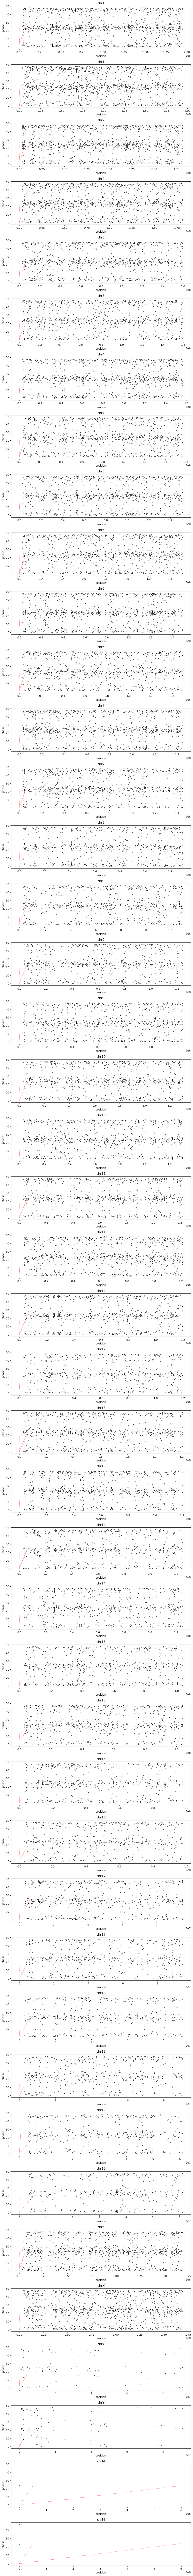

In [19]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# parameters
bin_size = 10000
T = np.arange(0,48,4)
Samples = [f'PRO_SEQ_CT{4*i:02d}_S{i+1}_R1_001' for i in range(12)]
Strands = ['+', '-']
CHR = [f'chr{i}' for i in range(1,20)] + ['chrX','chrY','chrM']

speed_nt_per_sec = np.array([6,70])
speed_nt_per_h = speed_nt_per_sec * 3600

# get dataset
data_folder='../results/phase_amp/'
df = pd.read_csv(f"{data_folder}/bin_phase_amp_{bin_size}bp.csv",sep='\t')


n_plot = len(CHR)*len(Strands)
#n_row = int(np.ceil(np.sqrt(n_plot)))
#if n_row % 2 == 1:
#    n_row += 1
#n_col = int(np.ceil(n_plot/n_row))
n_row = n_plot
n_col = 1
fig = plt.figure(figsize=(n_col*10,n_row*3))
f=0
for chr in CHR:
    print(chr)
    for strand in Strands:
        
        idx = (df.chr==chr) & (df.strand==strand) & (df.R2>0.5) & (df.amplitude>0.1)
        phi = df.loc[idx,'phase'].values/(2*np.pi)*24
        a = df.loc[idx,'amplitude'].values
        r2 = df.loc[idx,'R2'].values
        pos = (df.loc[idx,'start'].values + df.loc[idx,'end'].values)/2
        # rolling average of phase

        f+=1
        ax = fig.add_subplot(n_row,n_col,f)

        ax.plot([0,24*speed_nt_per_h[0]],[0,24],':r',alpha=0.5)
        ax.plot([0,24*speed_nt_per_h[1]],[0,24],':r',alpha=0.5)
        ax.scatter(pos,phi,s=5*a,marker='o',c='k',alpha=r2,rasterized=True)
        ax.scatter(pos,phi+24,s=5*a,marker='o',c='k',alpha=r2,rasterized=True)
        ax.set_xlabel('position')
        ax.set_ylabel('phase')
        ax.set_title(chr)
        plt.tight_layout()


plt.tight_layout()
plt.savefig('../results/fig/freq_amp.pdf')



<Axes: >

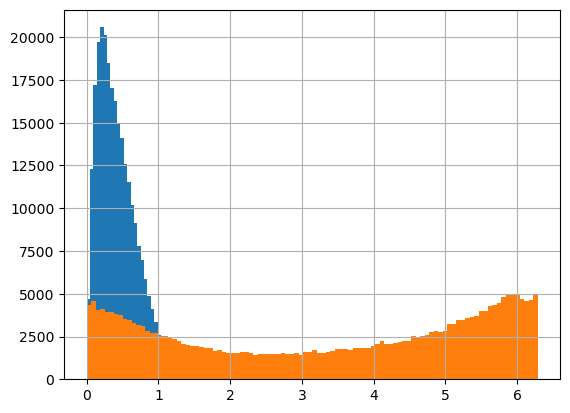

In [21]:
df.amplitude.hist(bins=100)

df.phase.hist(bins=100)


In [62]:
np.arange()

(1000,)